In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sample_data.tst_model import TST

In [55]:
# Load dataset
df = pd.read_csv('/content/sample_data/USDCHFM5.csv', encoding='utf-16', sep=r'\s*,\s*', engine='python', quotechar='"')
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Extra']
df['Date'] = pd.to_datetime(df['Date'].str.replace(r'^"|"$', '', regex=True).str.strip(), format='%Y.%m.%d %H:%M', errors='coerce')

In [56]:

# Konversi kolom DateTime ke tipe datetime, lalu jadikan index
df.set_index('Date', inplace=True)

# Print bossku
print(df.head())
print(df.dtypes)

                        Open     High      Low    Close  Volume  Extra
Date                                                                  
2022-07-12 09:20:00  0.98408  0.98427  0.98359  0.98390     462      0
2022-07-12 09:25:00  0.98389  0.98422  0.98355  0.98412     454      0
2022-07-12 09:30:00  0.98413  0.98451  0.98363  0.98390     581      0
2022-07-12 09:35:00  0.98390  0.98428  0.98370  0.98423     540      0
2022-07-12 09:40:00  0.98423  0.98442  0.98406  0.98417     477      0
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Extra       int64
dtype: object


In [57]:
# Jika ingin hanya mengambil kolom OHLC, bisa tambahkan volume dkk
ohlc = df[['Open','High','Low','Close']]
print(ohlc.head())

                        Open     High      Low    Close
Date                                                   
2022-07-12 09:20:00  0.98408  0.98427  0.98359  0.98390
2022-07-12 09:25:00  0.98389  0.98422  0.98355  0.98412
2022-07-12 09:30:00  0.98413  0.98451  0.98363  0.98390
2022-07-12 09:35:00  0.98390  0.98428  0.98370  0.98423
2022-07-12 09:40:00  0.98423  0.98442  0.98406  0.98417


In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
ohlc_scaled = scaler.fit_transform(ohlc)
print("Contoh hasil normalisasi:", ohlc_scaled[:3])

Contoh hasil normalisasi: [[0.80825532 0.80838774 0.80847714 0.80712446]
 [0.80706163 0.80807383 0.80822522 0.80850663]
 [0.80856945 0.80989453 0.80872906 0.80712446]]


In [59]:
def create_multistep_dataset(data, window_size=24, steps_ahead=5):
    X, y = [], []
    for i in range(len(data) - window_size - steps_ahead):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + steps_ahead])
    return np.array(X), np.array(y)

In [60]:
window_size = 24     # 1 jam (jika data pakai dataset usdchfm5)
steps_ahead = 5      # prediksi 5 bar ke depan 5x5menit = 25 menit

In [61]:
X, y = create_multistep_dataset(ohlc_scaled, window_size, steps_ahead)
print("X shape:", X.shape)  # (samples, 12, 4) 12 timestep dengan 4 fitur dataset OHLC gacor
print("y shape:", y.shape)  # (samples, 5, 4) 5 timestep prediksi ahead dengan4 fitur dataset OHLC gacor

X shape: (99985, 24, 4)
y shape: (99985, 5, 4)


In [62]:
# Split train-test tanpa shuffle (biar tetap urutan waktu)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [63]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (79988, 24, 4)
y_train shape: (79988, 5, 4)
X_test shape : (19997, 24, 4)
y_test shape : (19997, 5, 4)


In [64]:


class OHLCMultiStepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = OHLCMultiStepDataset(X_train, y_train)
test_dataset = OHLCMultiStepDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [65]:
# Ambil satu batch dari train_loader
for X_batch, y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("Contoh X_batch[0]:\n", X_batch[0])
    print("Contoh y_batch[0]:\n", y_batch[0])
    break  # supaya hanya print 1 batch


X_batch shape: torch.Size([64, 24, 4])
y_batch shape: torch.Size([64, 5, 4])
Contoh X_batch[0]:
 tensor([[0.5900, 0.5897, 0.5908, 0.5904],
        [0.5904, 0.5907, 0.5891, 0.5867],
        [0.5867, 0.5866, 0.5875, 0.5859],
        [0.5859, 0.5919, 0.5882, 0.5899],
        [0.5900, 0.5917, 0.5919, 0.5905],
        [0.5906, 0.5909, 0.5922, 0.5901],
        [0.5902, 0.5934, 0.5927, 0.5921],
        [0.5921, 0.5925, 0.5931, 0.5906],
        [0.5907, 0.5906, 0.5898, 0.5880],
        [0.5880, 0.5883, 0.5887, 0.5886],
        [0.5886, 0.5881, 0.5879, 0.5871],
        [0.5870, 0.5863, 0.5853, 0.5826],
        [0.5825, 0.5834, 0.5835, 0.5835],
        [0.5835, 0.5826, 0.5827, 0.5825],
        [0.5829, 0.5832, 0.5840, 0.5835],
        [0.5836, 0.5861, 0.5850, 0.5869],
        [0.5870, 0.5874, 0.5872, 0.5873],
        [0.5874, 0.5881, 0.5891, 0.5874],
        [0.5874, 0.5877, 0.5865, 0.5847],
        [0.5848, 0.5854, 0.5856, 0.5857],
        [0.5856, 0.5851, 0.5849, 0.5830],
        [0.5830, 0.58

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TST(c_in=4, c_out=5*4, seq_len=24).to(device)  # pastikan output 20
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)

# TST(
#     c_in=4,
#     c_out=5*4,
#     seq_len=12,
#     d_model=128,           # Dimensi embedding / representasi
#     n_heads=8,             # Jumlah attention head
#     d_k=16, d_v=16,        # Dimensi masing-masing head (opsional)
#     n_layers=3,            # Jumlah encoder layer
#     d_ff=256,              # Ukuran hidden layer pada feedforward
#     dropout=0.1,           # Dropout seluruh network
#     fc_dropout=0.0,        # Dropout pada final dense layer
#     act="gelu",            # Fungsi aktivasi (bisa diganti 'relu')
#     y_range=None,          # Bisa pakai range sigmoid output (contoh: (0,1))
# )


TST(
  (W_P): Linear(in_features=4, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): _TSTEncoder(
    (layers): ModuleList(
      (0-2): 3 x _TSTEncoderLayer(
        (self_attn): _MultiHeadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=False)
          (W_K): Linear(in_features=128, out_features=128, bias=False)
          (W_V): Linear(in_features=128, out_features=128, bias=False)
          (W_O): Linear(in_features=128, out_features=128, bias=False)
          (attention): _ScaledDotProductAttention()
        )
        (dropout_attn): Dropout(p=0.1, inplace=False)
        (batchnorm_attn): Sequential(
          (0): Transpose()
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Transpose()
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, i

In [67]:
# Model
model = TST(c_in=4, c_out=5*4, seq_len=24).to(device)


In [68]:
# Loss dan optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [69]:
# Config manual
epochs = 20
verbose = True

# Tracking loss
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).permute(0, 2, 1)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch).view(-1, 5, 4)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device).permute(0, 2, 1)
            y_batch = y_batch.to(device)

            output = model(X_batch).view(-1, 5, 4)
            val_loss = criterion(output, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if verbose:
        print(f"Epoch {epoch:02d}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")


Epoch 01/20 - Train Loss: 0.007750 - Val Loss: 0.000560
Epoch 02/20 - Train Loss: 0.001994 - Val Loss: 0.003558
Epoch 03/20 - Train Loss: 0.001840 - Val Loss: 0.012442
Epoch 04/20 - Train Loss: 0.001950 - Val Loss: 0.004694
Epoch 05/20 - Train Loss: 0.001804 - Val Loss: 0.010253
Epoch 06/20 - Train Loss: 0.002242 - Val Loss: 0.000057
Epoch 07/20 - Train Loss: 0.001945 - Val Loss: 0.000813
Epoch 08/20 - Train Loss: 0.001782 - Val Loss: 0.001844
Epoch 09/20 - Train Loss: 0.001813 - Val Loss: 0.002883
Epoch 10/20 - Train Loss: 0.002607 - Val Loss: 0.000167
Epoch 11/20 - Train Loss: 0.001807 - Val Loss: 0.001868
Epoch 12/20 - Train Loss: 0.001955 - Val Loss: 0.002517
Epoch 13/20 - Train Loss: 0.001730 - Val Loss: 0.002722
Epoch 14/20 - Train Loss: 0.001636 - Val Loss: 0.000111
Epoch 15/20 - Train Loss: 0.001610 - Val Loss: 0.000117
Epoch 16/20 - Train Loss: 0.001423 - Val Loss: 0.014313
Epoch 17/20 - Train Loss: 0.001376 - Val Loss: 0.000577
Epoch 18/20 - Train Loss: 0.001409 - Val Loss: 0

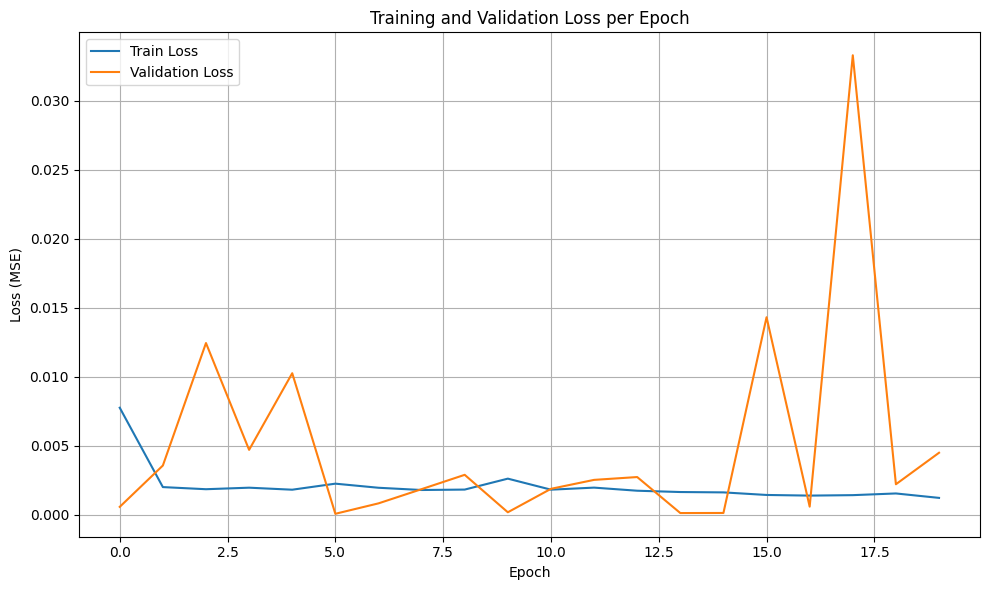

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [71]:
#Mclarenlu warna apa bos?
torch.save(model.state_dict(), "tst_USDCHF5_24Timestep.pt")
print("Model saved to 'tst_ohlc_model.pt'")


Model saved to 'tst_ohlc_model.pt'


In [72]:
# Ambil satu sample dari test set
sample_input = X_test[0]  # shape: (12, 4)
sample_input = torch.tensor(sample_input, dtype=torch.float32).unsqueeze(0)  # (1, 12, 4)
sample_input = sample_input.permute(0, 2, 1).to(device)  # jadi (1, 4, 12)

# Load model dan jalankan prediksi
model.eval()
with torch.no_grad():
    output = model(sample_input).view(-1, 5, 4).cpu().numpy()  # (1, 5, 4) → (5, 4)

# Tampilkan hasil prediksi
print("Hasil prediksi 5 langkah ke depan (Open, High, Low, Close):")
print(output[0])  # prediksi untuk langkah ke-1
print(output)     # semua 5 langkah

Hasil prediksi 5 langkah ke depan (Open, High, Low, Close):
[[0.3250773  0.3255094  0.32619342 0.32540482]
 [0.32522404 0.32570264 0.32610327 0.32505405]
 [0.32506993 0.32551932 0.32584316 0.32455853]
 [0.325051   0.3253006  0.3255968  0.32464793]
 [0.32491487 0.32521617 0.32541767 0.3246016 ]]
[[[0.3250773  0.3255094  0.32619342 0.32540482]
  [0.32522404 0.32570264 0.32610327 0.32505405]
  [0.32506993 0.32551932 0.32584316 0.32455853]
  [0.325051   0.3253006  0.3255968  0.32464793]
  [0.32491487 0.32521617 0.32541767 0.3246016 ]]]
